# Johan Hedenström
Exploration

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import math
import numpy as np
from utils import lists
from image_processing import process
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
chn = [2048,2048]
header, events, timing = lists.lstRead(FILE_PATH)

In [3]:
coin = [True, True, False, False, False, False, False, False]
zdrop = True
outLists = lists.getCoins(events,coin,zdrop)

In [4]:
X = np.array(outLists[0])
Y = np.array(outLists[1])

x, y = process(X, Y)

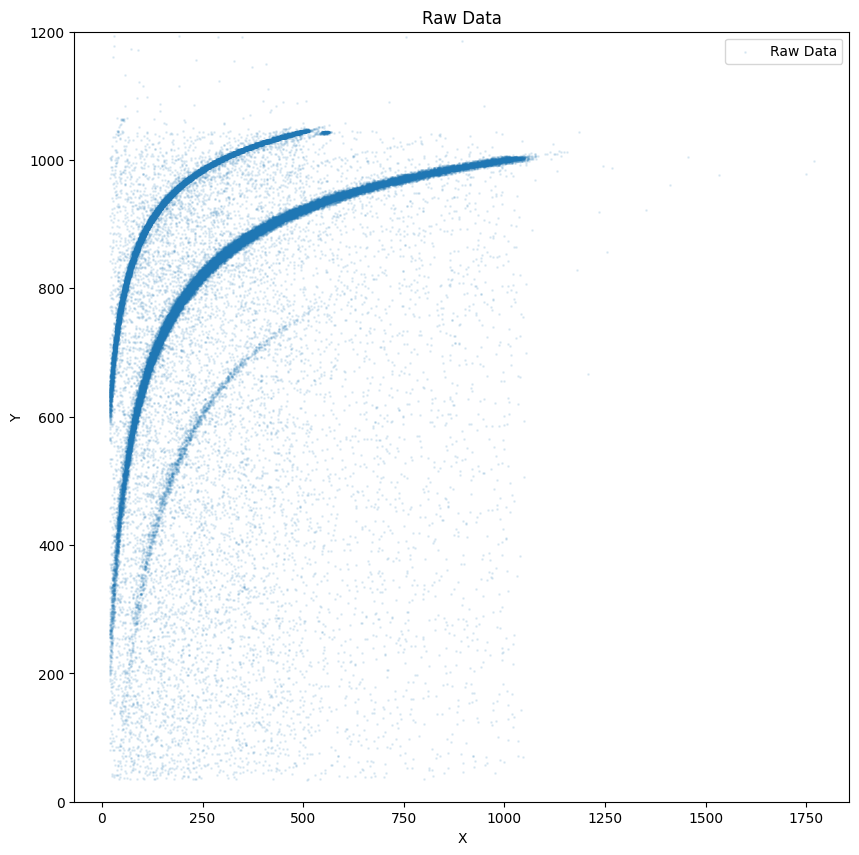

In [5]:
plt.figure(figsize=(10,10))

# Plot original data
plt.scatter(X, Y, s=1, alpha=0.1, label='Raw Data')

plt.title("Raw Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.ylim(0, 1200)
plt.show()

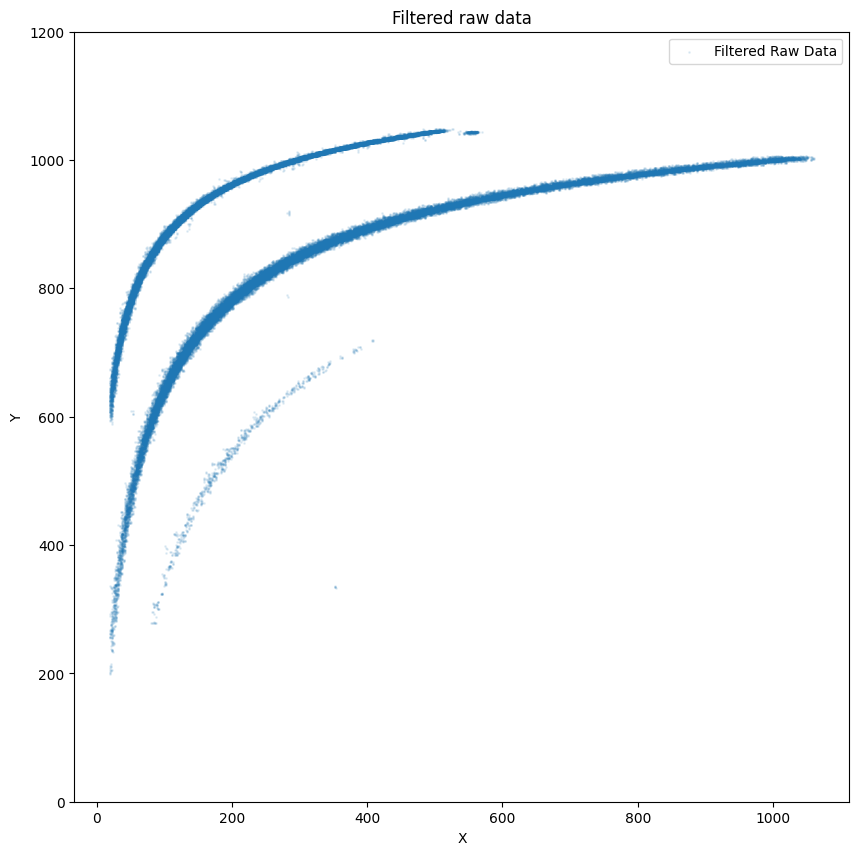

In [6]:
plt.figure(figsize=(10,10))

# Plot filtered data
plt.scatter(x, y, s=1, alpha=0.1, label='Filtered Raw Data')

plt.title("Filtered raw data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.ylim(0, 1200)
plt.show()

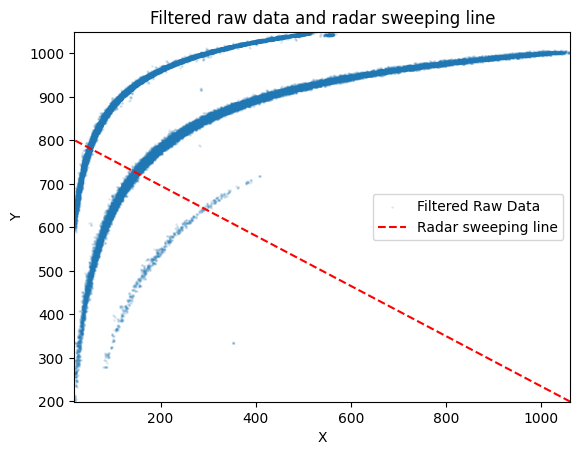

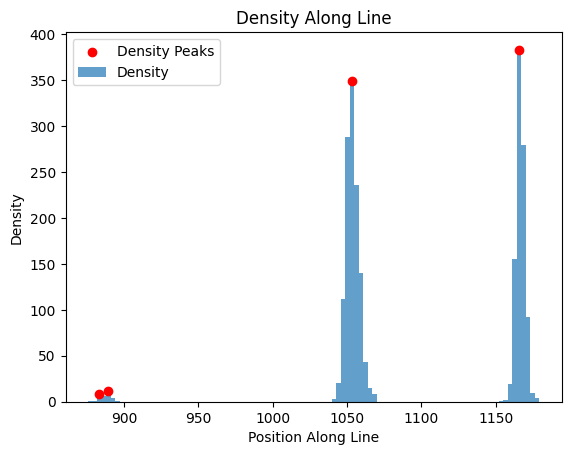

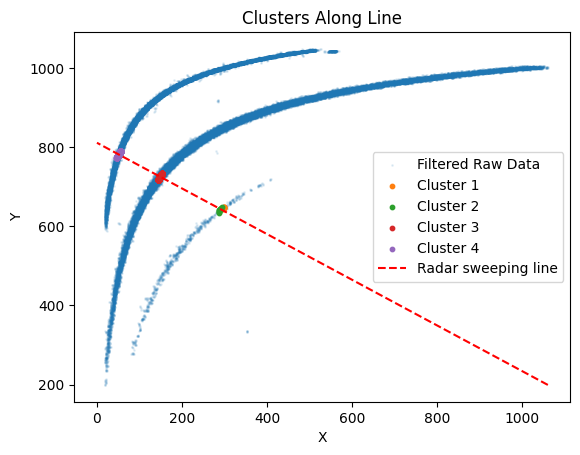

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# THIS BLOCK IS FOR ILLUSTRATION
# ------------------------------

# Define origin as bottom right
bottom_right_x = max(x)
bottom_right_y = min(y)

# Compute line length to extend across the data
angle = 30  # Degrees (clockwise from negative x-axis)
angle_rad = np.radians(angle)
length = max(x) / np.cos(angle_rad) if angle <= 45 else max(x) / np.sin(angle_rad)
end_x = bottom_right_x - length * np.cos(-angle_rad)
end_y = bottom_right_y - length * np.sin(-angle_rad)

# Calculate end point of line
end_x = bottom_right_x - length * np.cos(-angle_rad)
end_y = bottom_right_y - length * np.sin(-angle_rad)

# Plot data and radar line
plt.scatter(x, y, s=1, alpha=0.1, label='Filtered Raw Data')
plt.plot([bottom_right_x, end_x], [bottom_right_y, end_y], color="red", linestyle="--", label="Radar sweeping line")

plt.title("Filtered raw data and radar sweeping line")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.xlim([min(x), max(x)])
plt.ylim([min(y), max(y)])

plt.show()

# -- DENSITY HISTOGRAM ---------

# Line equation
line_vector = np.array([end_x - bottom_right_x, end_y - bottom_right_y])
line_vector /= np.linalg.norm(line_vector)

# Project points to line and compute distances
line_point = np.array([bottom_right_x, bottom_right_y])
data_points = np.column_stack((x, y))

projections = np.dot(data_points - line_point, line_vector)
projected_points = line_point + np.outer(projections, line_vector)

distances = np.linalg.norm(data_points - projected_points, axis=1)

# Only regard the closest points
distance_threshold = 10
mask = distances <= distance_threshold
filtered_projections = projections[mask]

# Segmentate line
num_segments = 100
line_min = filtered_projections.min() if len(filtered_projections) > 0 else 0
line_max = filtered_projections.max() if len(filtered_projections) > 0 else 1
segment_edges = np.linspace(line_min, line_max, num_segments + 1)
segment_centers = (segment_edges[:-1] + segment_edges[1:]) / 2

# Compute density in each segment
counts, _ = np.histogram(filtered_projections, bins=segment_edges)

# Find peaks in the density histogram
density_threshold = 5
peaks, _ = find_peaks(counts, height=density_threshold)
peak_positions = segment_centers[peaks]

# Plot density along the line and density peaks
plt.figure()
plt.bar(segment_centers, counts, width=(segment_edges[1] - segment_edges[0]), alpha=0.7, label='Density')
plt.scatter(peak_positions, counts[peaks], color='red', label='Density Peaks')
plt.xlabel("Position Along Line")
plt.ylabel("Density")
plt.title("Density Along Line")
plt.legend()
plt.show()

# Group points into clusters based on peak proximity
clusters = []
for peak in peak_positions:
    cluster_mask = (
        (projections >= peak - (segment_edges[1] - segment_edges[0]) / 2) &
        (projections <= peak + (segment_edges[1] - segment_edges[0]) / 2) &
        mask
    )
    clusters.append(data_points[cluster_mask])

# Plot clusters
plt.scatter(x, y, s=1, alpha=0.1, label='Filtered Raw Data')
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}', s=10)
plt.plot([bottom_right_x, end_x], [bottom_right_y, end_y], color="red", linestyle="--", label="Radar sweeping line")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Clusters Along Line")
plt.legend()
plt.show()


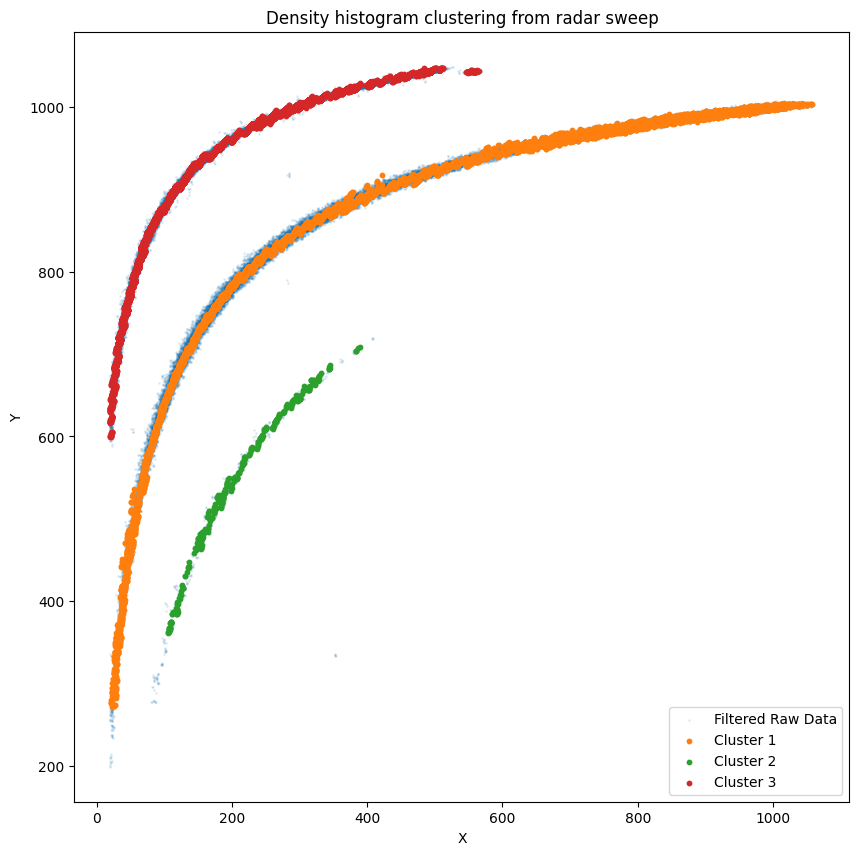

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Sweep parameters
angles = np.linspace(0, 90, 100)  # Discrete rotation angles (degrees, clockwise from negative x)
distance_threshold = 10  # Point distance threshold to the line
num_segments = 100  # Number of segments along the line
density_threshold = 5  # Minimum density to identify peaks
merge_distance = 50  # Distance threshold for merging clusters

# Initialize storage for clusters and histogram tracking
clusters = []
previous_peaks = None  # Store the previous histogram peaks

# Rotate the line through angles
for angle in angles:
    angle_rad = np.radians(angle)

    # Define origin as bottom right
    bottom_right_x = max(x)
    bottom_right_y = min(y)

    # Radar line
    length = max(x) / np.cos(angle_rad) if angle <= 45 else max(x) / np.sin(angle_rad)
    end_x = bottom_right_x - length * np.cos(-angle_rad)
    end_y = bottom_right_y - length * np.sin(-angle_rad)

    # Line equation
    line_vector = np.array([end_x - bottom_right_x, end_y - bottom_right_y])
    line_vector /= np.linalg.norm(line_vector)
    line_point = np.array([bottom_right_x, bottom_right_y])

    # Project points to line and compute distances
    data_points = np.column_stack((x, y))
    projections = np.dot(data_points - line_point, line_vector)
    projected_points = line_point + np.outer(projections, line_vector)
    distances = np.linalg.norm(data_points - projected_points, axis=1)

    # Only regard the closest points
    mask = distances <= distance_threshold
    filtered_projections = projections[mask]

    # Line segements
    line_min = filtered_projections.min() if len(filtered_projections) > 0 else 0
    line_max = filtered_projections.max() if len(filtered_projections) > 0 else 1
    segment_edges = np.linspace(line_min, line_max, num_segments + 1)
    segment_centers = (segment_edges[:-1] + segment_edges[1:]) / 2

    # Count points in each segment
    counts, _ = np.histogram(filtered_projections, bins=segment_edges)

    # Find peaks in the density histogram
    peaks, _ = find_peaks(counts, height=density_threshold)
    current_peaks = segment_centers[peaks]

    # Compare current peaks with previous peaks to track and merge clusters
    if previous_peaks is not None:
        for peak in current_peaks:
            # Check if the peak is close to an existing cluster
            found_cluster = False
            for cluster in clusters:
                if abs(peak - cluster['peak']) < merge_distance:
                    # Update the cluster's peak position and add new points
                    cluster['peak'] = peak
                    cluster['points'].extend(data_points[
                        (projections >= peak - (segment_edges[1] - segment_edges[0]) / 2) &
                        (projections <= peak + (segment_edges[1] - segment_edges[0]) / 2) &
                        mask
                    ])
                    found_cluster = True
                    break
            if not found_cluster:
                # Create a new cluster if no match is found
                clusters.append({
                    'peak': peak,
                    'points': list(data_points[
                        (projections >= peak - (segment_edges[1] - segment_edges[0]) / 2) &
                        (projections <= peak + (segment_edges[1] - segment_edges[0]) / 2) &
                        mask
                    ])
                })
    else:
        # Initialize clusters
        for peak in current_peaks:
            clusters.append({
                'peak': peak,
                'points': list(data_points[
                    (projections >= peak - (segment_edges[1] - segment_edges[0]) / 2) &
                    (projections <= peak + (segment_edges[1] - segment_edges[0]) / 2) &
                    mask
                ])
            })

    # Update previous peaks
    previous_peaks = current_peaks

final_clusters = [np.array(cluster['points']) for cluster in clusters]

# Plot result
plt.figure(figsize=(10, 10))
plt.scatter(x, y, s=1, alpha=0.1, label='Filtered Raw Data')
for i, cluster in enumerate(final_clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], s=10, label=f'Cluster {i+1}')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Density histogram clustering from radar sweep")
plt.legend()
plt.show()

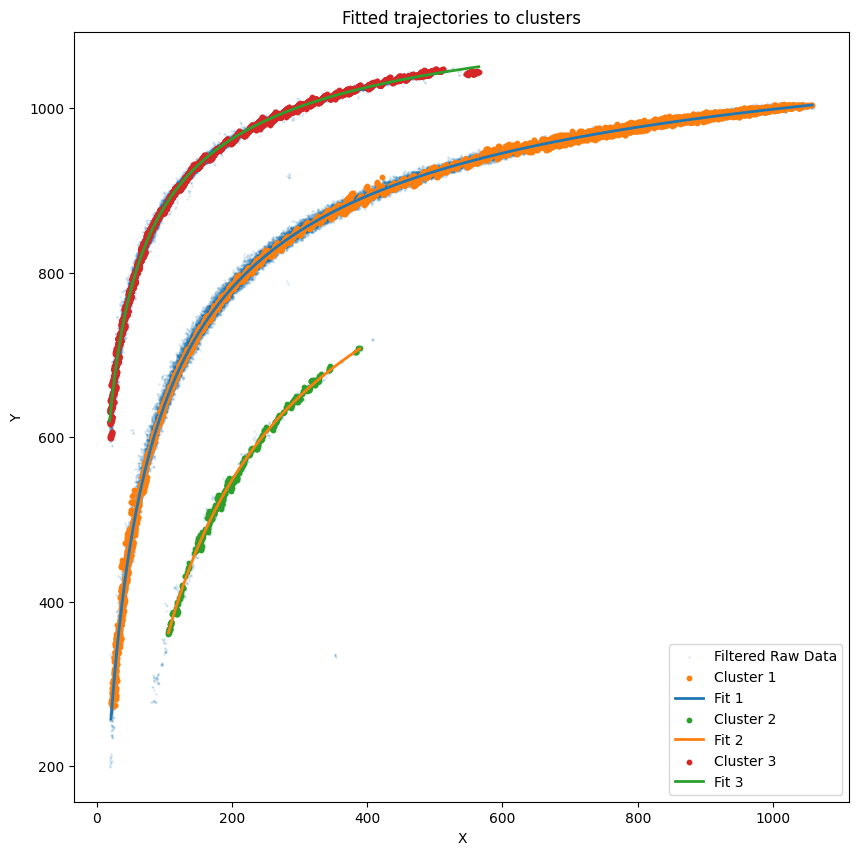

Cluster 1: a = 6046.418, b = 21.174, c = 1188.165
Cluster 2: a = 9338.251, b = 29.550, c = 1164.079
Cluster 3: a = 3279.332, b = 14.403, c = 1186.921


In [9]:
from scipy.optimize import curve_fit

# Trajectory model
def model(x, a, b, c):
    return -a / np.sqrt(x + b) + c

# Fit function to each cluster
fitted_parameters = []

plt.figure(figsize=(10, 10))
plt.scatter(x, y, s=1, alpha=0.1, label='Filtered Raw Data')

for i, cluster in enumerate(final_clusters):
    cluster_x = cluster[:, 0]
    cluster_y = cluster[:, 1]

    sort_idx = np.argsort(cluster_x)
    cluster_x = cluster_x[sort_idx]
    cluster_y = cluster_y[sort_idx]
    min_x = np.min(cluster_x)
    shift_x = 0 if min_x > 0 else -min_x + 1e-5
    shifted_x = cluster_x + shift_x

    # Fit curve
    try:
        popt, _ = curve_fit(model, shifted_x, cluster_y, bounds=(0, np.inf))
        fitted_parameters.append(popt)

        x_fit = np.linspace(np.min(shifted_x), np.max(shifted_x), 500)
        y_fit = model(x_fit, *popt)

        # Plot fitted curve
        plt.scatter(cluster_x, cluster_y, s=10, label=f'Cluster {i+1}')
        plt.plot(x_fit - shift_x, y_fit, label=f'Fit {i+1}', linewidth=2)
    except RuntimeError:
        print(f"Fit failed for Cluster {i+1}")
        continue

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Fitted trajectories to clusters")
plt.legend()
plt.show()

# Display fitted parameters
for i, params in enumerate(fitted_parameters):
    print(f"Cluster {i+1}: a = {params[0]:.3f}, b = {params[1]:.3f}, c = {params[2]:.3f}")


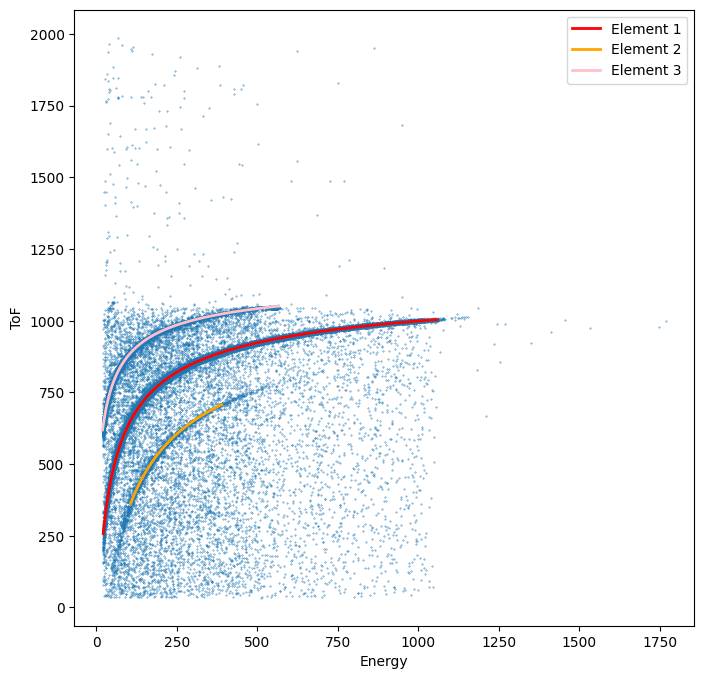

In [10]:
import matplotlib.colors as mcolors

custom_colors = [
    'red', 'orange', 'pink', 'cyan', 'yellow', 'lime', 'magenta'
]

plt.figure(figsize=(8, 8))
plt.scatter(X, Y, s=0.1)

for i, params in enumerate(fitted_parameters):
    a, b, c = params 
    cluster = final_clusters[i]

    cluster_x = cluster[:, 0]
    min_x, max_x = np.min(cluster_x), np.max(cluster_x)
    x_fit = np.linspace(min_x, max_x, 500)
    y_fit = model(x_fit, a, b, c)

    plt.plot(x_fit, y_fit, linewidth=2, label=f'Element {i+1}', color=custom_colors[i % len(custom_colors)])

plt.xlabel("Energy")
plt.ylabel("ToF")
plt.legend()
plt.show()